### 1. Importing packages

In [1]:
!pip install pandas-datareader==0.10.0


[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install statsmodels


[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import datetime
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

import random

import torch
import torch.nn as nn
from torch.autograd import Variable

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from scipy.optimize import minimize


### 2. Loading dataset

In [4]:
# top 30 U.S. companies by market capitalization
# except ABBV, FB, TSLA: listed after 2009-12-31
#tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'BRK-A', 'NVDA', 'V', 'JPM', 'UNH', 
#           'JNJ', 'BAC', 'WMT', 'PG', 'HD', 'MA', 'XOM', 'PFE', 'DIS', 'CVX', 
#           'KO', 'AVGO', 'PEP', 'CSCO', 'WFC', 'COST', 'LLY', 'ADBE']
tickers = ['AAPL', 'MSFT']

In [5]:
start_time = '2009-12-31' # 2009-12-31
end_time = '2021-12-31' # 2021-12-31

In [6]:
# where to split training and validation datasets
all_split = 2517 # start 31/12/2009, val 02/01/2020, end 31/12/2021
# abbv_split = 1762 # start 02/01/2013
# fb_split = 1917 # start 18/05/2012
# tsla_split = 2394 # start 29/06/2010

In [7]:
str(start_time)

'2009-12-31'

In [8]:
# getting datetimeindex
df = pdr.get_data_yahoo(tickers[0], start=start_time, end=end_time)
df.index = pd.to_datetime(df.index)

[*********************100%***********************]  1 of 1 completed


In [9]:
# dataframe for Adj Close price
act_adj_close_df = pd.DataFrame(index=df.index, columns=tickers)
for ticker in tickers:
    stock_price_df = pdr.get_data_yahoo(ticker, start_time, end_time)
    stock_price_df.index = pd.to_datetime(stock_price_df.index)
    act_adj_close_df[ticker] = stock_price_df['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [10]:
act_adj_close_df.head()

,AAPL,MSFT
Date,,
2009-12-30,6.415689,23.530167
2009-12-31,6.388104,23.165359
2010-01-04,6.487534,23.522570
2010-01-05,6.498749,23.530167
2010-01-06,6.395379,23.385763


In [11]:
# plotting parameters
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 12})

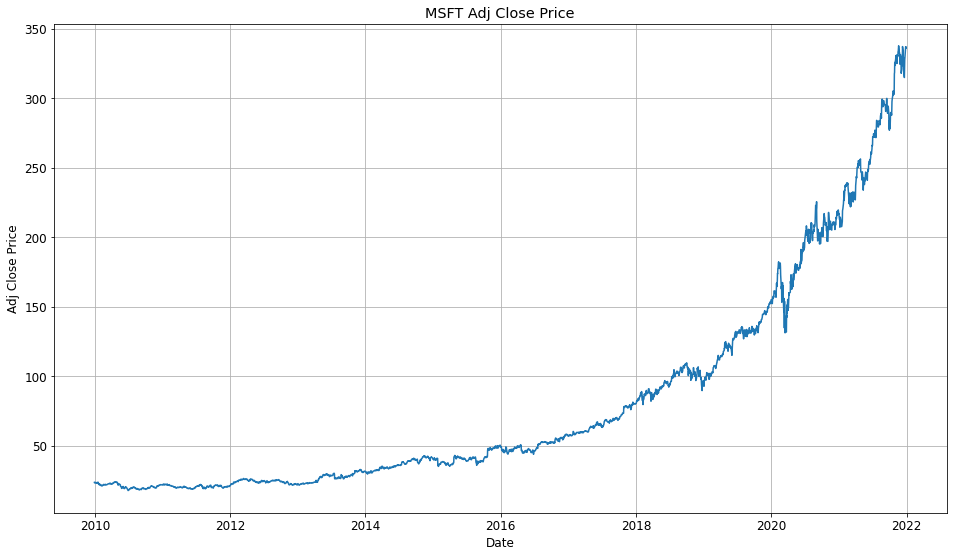

In [14]:
# plotting Adj Close price distribution of random ticker
rand_ticker = random.choice(tickers)
plt.plot(act_adj_close_df[rand_ticker].index.values, act_adj_close_df[rand_ticker].values)
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title(f'{rand_ticker} Adj Close Price')
plt.show()

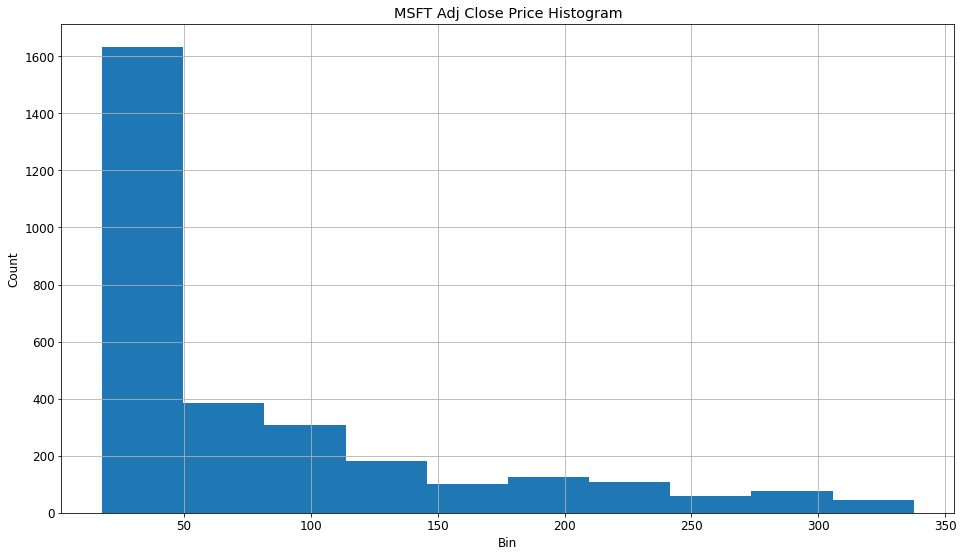

In [15]:
# histogram
plt.hist(act_adj_close_df[rand_ticker].values)
plt.xlabel('Bin')
plt.ylabel('Count')
plt.title(f'{rand_ticker} Adj Close Price Histogram')
plt.show()

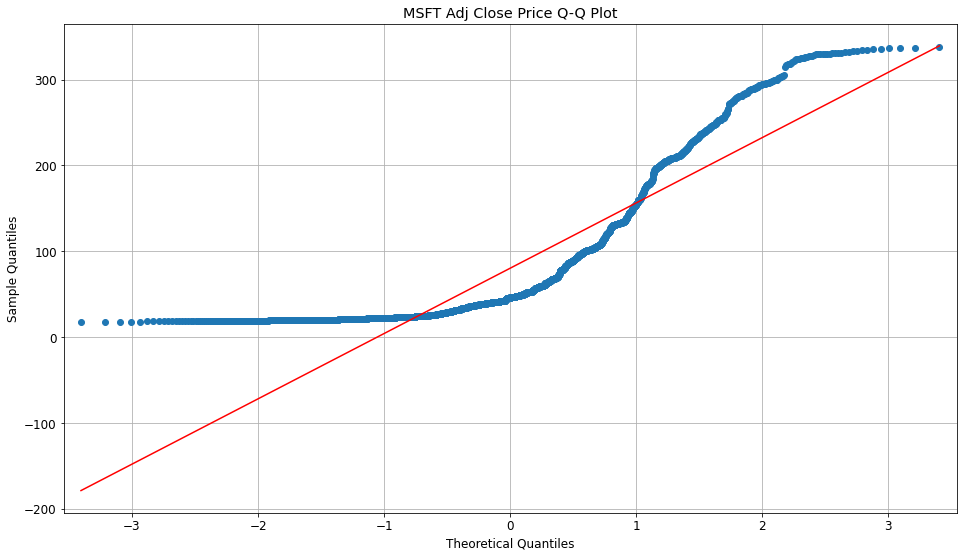

In [16]:
# q-q plot
qqplot(act_adj_close_df[rand_ticker].values, line='s')
plt.title(f'{rand_ticker} Adj Close Price Q-Q Plot')
plt.show()

In [17]:
act_adj_close_df.to_csv('act-adj-close-df.csv')

### 3. Building LSTM model

In [18]:
act_adj_close_df = pd.read_csv('data/act-adj-close-df.csv', index_col=0)
act_adj_close_df.index = pd.to_datetime(act_adj_close_df.index)

In [19]:
act_adj_close_df

,AAPL,MSFT,GOOG,AMZN,BRK-A,NVDA,V,JPM,UNH,JNJ,...,DIS,CVX,KO,AVGO,PEP,CSCO,WFC,COST,LLY,ADBE
Date,,,,,,,,,,,,,,,,,,,,,
2009-12-31,6.444381,23.493387,308.832428,134.520004,99200,4.289911,20.057911,30.619146,25.439573,44.963562,...,28.090706,47.191059,19.632374,13.908897,42.725761,17.431417,19.624825,43.977604,24.205421,36.779999
2010-01-04,6.544686,23.855658,312.204773,133.899994,99600,4.246276,20.213861,31.524036,26.315939,45.152031,...,27.933920,48.459877,19.646151,14.342362,43.034954,17.977512,19.864773,44.155975,24.279980,37.090000
2010-01-05,6.556004,23.863365,310.829926,134.690002,99710,4.308283,19.982225,32.134651,26.274208,44.628471,...,27.864235,48.803131,19.408495,14.448830,43.554989,17.897417,20.410110,44.022202,23.852945,37.700001
2010-01-06,6.451720,23.716915,302.994293,132.250000,99850,4.335841,19.713909,32.311211,26.532948,44.991478,...,27.716164,48.809258,19.401613,14.562894,43.119297,17.780920,20.439198,44.594498,24.029184,37.619999
2010-01-07,6.439794,23.470270,295.940735,130.000000,100000,4.250867,19.897379,32.951263,27.551197,44.670376,...,27.724874,48.625378,19.353386,14.471641,42.845226,17.861012,21.180857,44.378941,23.907177,36.889999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,180.100540,341.743378,2961.280029,3393.389893,447110,309.450012,217.276505,157.217621,499.500000,168.587799,...,152.800003,117.555779,58.650002,674.280029,171.470001,63.048477,48.552006,562.617249,277.252625,577.679993
2021-12-28,179.061859,340.545837,2928.959961,3413.219971,449570,303.220001,217.695831,157.694748,502.940002,169.263474,...,155.199997,117.328163,58.880001,669.000000,172.360001,63.157833,48.203568,563.785522,275.280853,569.359985
2021-12-29,179.151749,341.244415,2930.090088,3384.020020,452102,300.010010,217.815628,157.615234,505.579987,170.455811,...,154.869995,116.724495,58.950001,672.609985,172.970001,63.585312,48.233437,566.910767,277.262573,569.289978


In [20]:
# selecting gpu
device = torch.device('cuda')

In [21]:
class LSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM_model, self).__init__()
        self.input_size = input_size # number of features
        self.hidden_size = hidden_size # number of features in hidden state
        self.num_layers = num_layers # number of stacked LSTM layers
        self.num_classes = num_classes # number of output classes
    
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True) # LSTM layer
        self.fc = nn.Linear(hidden_size, num_classes) # fully connected last layer

    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), 
                                  self.hidden_size)).to(device) # hidden state
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), 
                                  self.hidden_size)).to(device) # internal state
        # propagating input through LSTM
        out, _ = self.lstm(x, (h0, c0)) # out: tensor of shape (seq_length, batch_size, hidden_size)
        # decoding hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out

In [22]:
import torch
import torch.nn as nn
import copy
import math
import torch.nn.functional as F
from torch.autograd import Variable

device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def creatMask(batch, sequence_length):
    mask = torch.zeros(batch, sequence_length, sequence_length)
    for i in range(sequence_length):
        mask[:, i, :i + 1] = 1
    return mask


class Norm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super().__init__()

        self.size = d_model

        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))

        self.eps = eps

    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
               / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm


def attention(q, k, v, d_k, mask=None, dropout=None, returnWeights=False):
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)

    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)

    scores = F.softmax(scores, dim=-1)

    if dropout is not None:
        scores = dropout(scores)
    output = torch.matmul(scores, v)
    # print("Scores in attention itself",torch.sum(scores))
    if (returnWeights):
        return output, scores

    return output


class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout=0.1):
        super().__init__()

        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None, returnWeights=False):

        bs = q.size(0)

        # perform linear operation and split into N heads
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)

        # transpose to get dimensions bs * N * sl * d_model
        k = k.transpose(1, 2)
        q = q.transpose(1, 2)
        v = v.transpose(1, 2)
        # calculate attention using function we will define next

        if (returnWeights):
            scores, weights = attention(q, k, v, self.d_k, mask, self.dropout, returnWeights=returnWeights)
            # print("scores",scores.shape,"weights",weights.shape)
        else:
            scores = attention(q, k, v, self.d_k, mask, self.dropout)

        # concatenate heads and put through final linear layer
        concat = scores.transpose(1, 2).contiguous() \
            .view(bs, -1, self.d_model)
        output = self.out(concat)
        # print("Attention output", output.shape,torch.min(output))
        if (returnWeights):
            return output, weights
        else:
            return output


class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=400, dropout=0.1):
        super().__init__()

        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x


class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, mask=None, returnWeights=False):
        x2 = self.norm_1(x)
        # print(x2[0,0,0])
        # print("attention input.shape",x2.shape)
        if (returnWeights):
            attenOutput, attenWeights = self.attn(x2, x2, x2, mask, returnWeights=returnWeights)
        else:
            attenOutput = self.attn(x2, x2, x2, mask)
        # print("attenOutput",attenOutput.shape)
        x = x + self.dropout_1(attenOutput)
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        if (returnWeights):
            return x, attenWeights
        else:
            return x


class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len=100, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)
        # create constant 'pe' matrix with values dependant on
        # pos and i
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = \
                    math.sin(pos / (10000 ** ((2 * i) / d_model)))
                if (i + 1) < d_model:
                    pe[pos, i + 1] = \
                        math.cos(pos / (10000 ** ((2 * (i + 1)) / d_model)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        # add constant to embedding
        seq_len = x.size(1)

        pe = Variable(self.pe[:, :seq_len], requires_grad=False)

        if x.is_cuda:
            pe.cuda()
        x = x + pe
        return self.dropout(x)


def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])


class Encoder(nn.Module):
    def __init__(self, input_size, seq_len, N, heads, dropout):
        super().__init__()
        self.N = N
        self.pe = PositionalEncoder(input_size, seq_len, dropout=dropout)
        self.layers = get_clones(EncoderLayer(input_size, heads, dropout), N)
        self.norm = Norm(input_size)

    def forward(self, x, mask=None, returnWeights=False):
        x = self.pe(x)

        for i in range(self.N):
            if (i == 0 and returnWeights):
                x, weights = self.layers[i](x, mask=mask, returnWeights=returnWeights)
            else:
                # print(i)
                x = self.layers[i](x, mask=mask)

        if (returnWeights):
            return self.norm(x), weights
        else:
            return self.norm(x)


class Transformer(nn.Module):
    def __init__(self, n_feature, n_timestep, n_layer, n_head, n_dropout, n_output, lb, ub):
        super().__init__()
        self.encoder = Encoder(n_feature, n_timestep, n_layer, n_head, n_dropout)
        self.out = nn.Linear(n_feature, n_output)
        self.tempmaxpool = nn.MaxPool1d(n_timestep)
        self.lb = lb
        self.ub = ub

    def forward(self, src, returnWeights=False):
        mask = creatMask(src.shape[0], src.shape[1]).to(device)
        # print(src.shape)
        if (returnWeights):
            e_outputs, weights, z = self.encoder(src, mask, returnWeights=returnWeights)
        else:
            e_outputs = self.encoder(src, mask)

        e_outputs = self.tempmaxpool(e_outputs.transpose(1, 2)).squeeze(-1)
        output = self.out(e_outputs)
        output = F.softmax(output, dim=1)
        output = torch.stack([self.rebalance(batch, self.lb, self.ub) for batch in output])
        if (returnWeights):
            return output, weights
        else:
            return output

    def rebalance(self, weight, lb, ub):
        old = weight
        weight_clamped = torch.clamp(old, lb, ub)
        while True:
            leftover = (old - weight_clamped).sum().item()
            nominees = weight_clamped[torch.where(weight_clamped != ub)[0]]
            gift = leftover * (nominees / nominees.sum())
            weight_clamped[torch.where(weight_clamped != ub)[0]] += gift
            old = weight_clamped
            if len(torch.where(weight_clamped > ub)[0]) == 0:
                break
            else:
                weight_clamped = torch.clamp(old, lb, ub)
        return weight_clamped

In [36]:
# function for building model
def build_model(input_size=1, hidden_size=1, num_layers=1, num_classes=1, learning_rate=0.001):
    # learning rate controls how much to change model in response to estm error 
    # each time model weights are updated
    
    model = LSTM_model(input_size, hidden_size, num_layers, num_classes).to(device)
    #model = Transformer(input_size, time_step, num_layers, 1, 0.1, num_classes, learning_rate, 0.2)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # adam optimizer
    # algorithms/methods to change attributes of neural network such as weights and learning rate to reduce losses

    loss_function = torch.nn.MSELoss() # mean-squared error of regression
    # loss function measures how bad model performs: high loss -> low accuracy

    # loading model state
    # model = LSTM_model(*args, **kwargs)
    # model.load_state_dict(torch.load(PATH))
    # model.eval()

    return model, optimizer, loss_function

### 4. Model fitting and evaluation

In [24]:
# scaler for normalizing dataset
scaler = MinMaxScaler()

In [25]:
# function for creating X and y
def create_xy(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:i + time_step])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

In [26]:
time_step = 100

In [27]:
# dataframes for model loss, predicted Adj Close price and model performance
model_loss_df = pd.DataFrame(index=[epoch for epoch in range(0, 11000, 1000)], columns=tickers)
#pred_adj_close_df = pd.DataFrame(index=df.index[time_step + 1:], columns=tickers)
pred_adj_close_df = pd.DataFrame(index=act_adj_close_df.index[time_step + 1:], columns=tickers)
model_perf_df = pd.DataFrame(index=['MAE', 'MSE', 'RMSE', 'MAPE', 'MPE'], columns=tickers)

In [28]:
# functions for model performance evaluation
def MAE(y_true, y_hat):
    return np.mean(np.abs(y_true - y_hat))

def MSE(y_true, y_hat):
    return np.mean(np.square(y_true - y_hat))

def RMSE(y_true, y_hat):
    return np.sqrt(MSE(y_true, y_hat))

def MAPE(y_true, y_hat):
    return np.mean(np.abs((y_true - y_hat) / y_true)) * 100

def MPE(y_true, y_hat):
    return np.mean((y_true - y_hat) / y_true) * 100

In [55]:
# function for fitting model
def fit_model(ticker, X_train, y_train):
    model, optimizer, loss_function = build_model()
    num_epochs = 1000
    
    loss_list = []

    for epoch in range(num_epochs + 1):
        outputs = model.forward(X_train.to(device)) # forward pass
        optimizer.zero_grad() # calculating gradient, manually setting to 0
        loss = loss_function(outputs, y_train.to(device)) # obtaining loss
        loss.backward() # calculating loss of loss function
        optimizer.step() # improving from loss, i.e. backprop
        
        if epoch % 100 == 0:
            loss_list.append(loss.item())
    
    model_loss_df[ticker] = loss_list

    # saving model state
    torch.save(model.state_dict(), f'data/model-states/{ticker}-model-state.pth')
    
    return model

In [30]:
[tickers[0]]

['AAPL']

In [32]:
time_step

100

In [56]:
# fitting models and predicting responses
for ticker in tickers:
#for ticker in [tickers[0]]:
    # normalizing dataset
    norm_act_adj_close = scaler.fit_transform(np.array(act_adj_close_df[ticker]).reshape(-1, 1))

    # if ticker == 'ABBV':
    #     train_set, val_set = norm_act_adj_close[:abbv_split], norm_act_adj_close[abbv_split:]
    # elif ticker == 'FB':
    #     train_set, val_set = norm_act_adj_close[:fb_split], norm_act_adj_close[fb_split:]
    # elif ticker == 'TSLA':
    #     train_set, val_set = norm_act_adj_close[:tsla_split], norm_act_adj_close[tsla_split:]
    # else:
    train_set, val_set = norm_act_adj_close[:all_split], norm_act_adj_close[all_split:]

    X_train, y_train = create_xy(train_set, time_step)
    X_val, y_val = create_xy(norm_act_adj_close, time_step)

    # converting datasets to tensors
    X_train_tensors = Variable(torch.Tensor(X_train))
    y_train_tensors = Variable(torch.Tensor(y_train))

    X_val_tensors = Variable(torch.Tensor(X_val))
    y_true = scaler.inverse_transform(y_val) # inverse transformation
    
    # fitting model
    print('----------')
    print(f'{ticker} fitting...')
    print(f'{len(tickers) - (tickers.index(ticker) + 1)} left')
    model = fit_model(ticker=ticker, X_train=X_train_tensors, y_train=y_train_tensors)

    # predicting response
    y_hat = model(X_val_tensors.to(device)) # forward pass
    y_hat = y_hat.data.detach().cpu().numpy() # numpy conversion
    y_hat = scaler.inverse_transform(y_hat) # inverse transformation
    print('Done!')
    
    pred_adj_close_df[ticker] = y_hat
    
    model_perf_df[ticker] = [MAE(y_true, y_hat), MSE(y_true, y_hat), RMSE(y_true, y_hat), 
                             MAPE(y_true, y_hat), MPE(y_true, y_hat)]

----------
AAPL fitting...
1 left
Done!
----------
MSFT fitting...
0 left
Done!


In [57]:
train_set.shape

(2517, 1)

In [39]:
X_train.shape

(2416, 100, 1)

In [58]:
y_train.shape

(2416, 1)

In [59]:
np.array(act_adj_close_df[tickers[0]])

array([  6.44438124,   6.54468632,   6.55600357, ..., 179.15174866,
       177.97325134, 177.34405518])

In [60]:
pred_adj_close_df[tickers[0]]

Date
2010-05-27    26.566896
2010-05-28    26.566523
2010-06-01    26.567516
2010-06-02    26.569958
2010-06-03    26.572481
                ...    
2021-12-27    53.988678
2021-12-28    54.038582
2021-12-29    54.149117
2021-12-30    54.181973
2021-12-31    54.203022
Name: AAPL, Length: 2921, dtype: float32

In [61]:
X_train_tensors.shape

torch.Size([2416, 100, 1])

### 5. Results

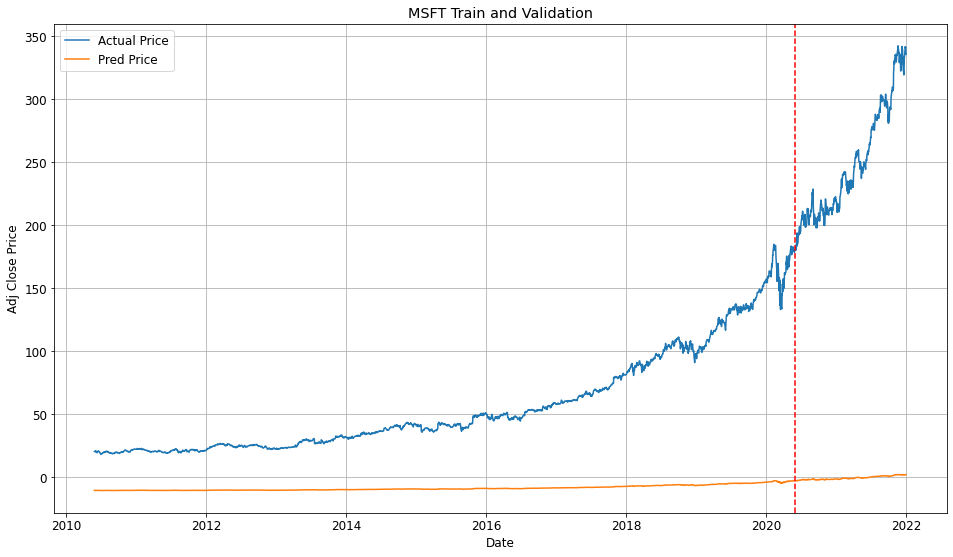

In [62]:
# plotting actual and predicted Adj Close price of random ticker
rand_ticker = random.choice(tickers)
plt.plot(pred_adj_close_df.index.values, act_adj_close_df[rand_ticker][time_step + 1:].values, label='Actual Price')
plt.plot(pred_adj_close_df.index.values, pred_adj_close_df[rand_ticker].values, label='Pred Price')
plt.axvline(x=pred_adj_close_df.index[all_split], c='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title(f'{rand_ticker} Train and Validation')
plt.legend()
plt.show()

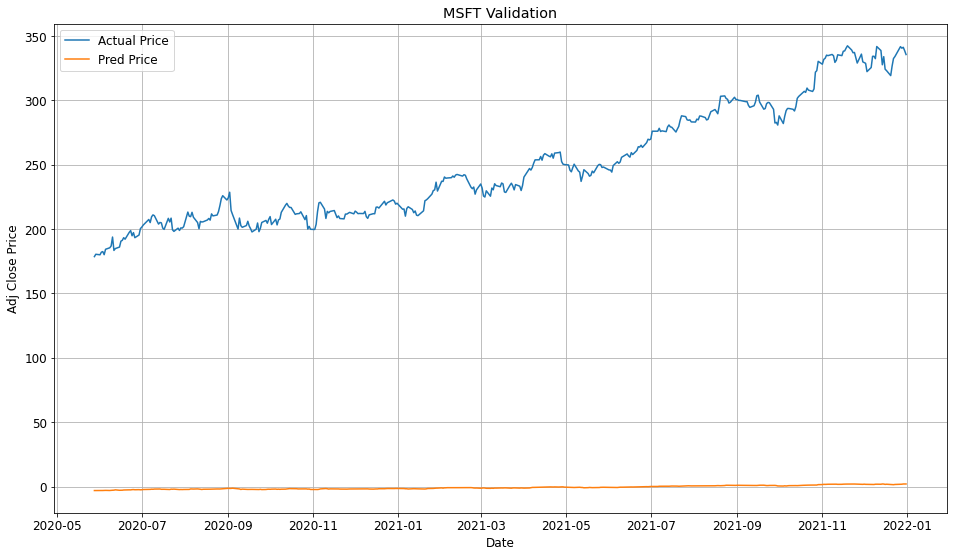

In [63]:
val_act = act_adj_close_df[rand_ticker][time_step + 1 + all_split:]
val_pred = pred_adj_close_df[rand_ticker][all_split:]

plt.plot(pred_adj_close_df.index[all_split:].values, val_act.values, label='Actual Price')
plt.plot(pred_adj_close_df.index[all_split:].values, val_pred.values, label='Pred Price')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title(f'{rand_ticker} Validation')
plt.legend()
plt.show()

In [ ]:
print(f'Val RMSE: {mean_squared_error(val_act, val_pred, squared=True)}')

In [ ]:
model_loss_df.tail()

In [ ]:
pred_adj_close_df.head()

In [ ]:
model_perf_df

In [ ]:
model_loss_df.to_csv('model-loss-df.csv')
pred_adj_close_df.to_csv('pred-adj-close-df.csv')
model_perf_df.to_csv('model-perf-df.csv')

In [ ]:
# act_adj_close_df = pd.read_csv('act-adj-close-df.csv', index_col=0)
# act_adj_close_df.index = pd.to_datetime(act_adj_close_df.index)

# model_loss_df = pd.read_csv('model-loss-df.csv', index_col=0)

# pred_adj_close_df = pd.read_csv('pred-adj-close-df.csv', index_col=0)
# pred_adj_close_df.index = pd.to_datetime(pred_adj_close_df.index)

# model_perf_df = pd.read_csv('model-perf-df.csv', index_col=0)

### 6. Building portfolios

In [ ]:
# daily returns of actual Adj Close price (validation phase)
act_adj_close_val_df = act_adj_close_df.iloc[time_step + 1 + all_split:, :]
act_daily_ret_df = act_adj_close_val_df.pct_change()
act_daily_ret_df = act_daily_ret_df.iloc[1:, :]
act_daily_ret_df.head()

In [ ]:
# daily returns of predicted Adj Close price (validation phase)
pred_adj_close_val_df = pred_adj_close_df.iloc[all_split:, :]
pred_daily_ret_df = pred_adj_close_val_df.pct_change()
pred_daily_ret_df = pred_daily_ret_df.iloc[1:, :]
pred_daily_ret_df.head()

In [ ]:
# dataframe for daily portfolio returns
act_daily_port_ret_df = act_daily_ret_df.copy()
act_daily_port_ret_df.drop(columns=tickers, inplace=True)

In [ ]:
# risk free return
risk_free_ret = 0.015

In [ ]:
# function for adding different portfolios
def add_portfolio(portfolio, weights):
    act_daily_port_ret_df[f'{portfolio} Return'] = act_daily_ret_df.dot(weights)
    if portfolio == 'Pred':
        # upper bound of security transaction tax: 0.0003
        act_daily_port_ret_df[f'{portfolio} Return'] = act_daily_port_ret_df[f'{portfolio} Return'] - 0.0003
    act_daily_port_ret_df[f'{portfolio} Cum Prod Return'] = (1 + act_daily_port_ret_df[f'{portfolio} Return']).cumprod()

    exp_ret = act_daily_port_ret_df[f'{portfolio} Return'].mean()
    std = act_daily_port_ret_df[f'{portfolio} Return'].std()
    sharpe_ratio = (exp_ret - risk_free_ret) / std

    print(portfolio)
    print('Weights:')
    print(weights)
    print(f'Expected Return: {exp_ret:.6f}')
    print(f'Standard Dev   : {std:.6f}')
    print(f'Sharpe Ratio   : {sharpe_ratio:.6f}')

In [ ]:
act_daily_port_ret_df

In [ ]:
act_daily_port_ret_df['Pred Return']

In [ ]:
(1 + act_daily_port_ret_df['Pred Return'])

In [ ]:
(1 + act_daily_port_ret_df['Pred Return']).cumprod()

#### Equally weighted portfolio

In [ ]:
n_assets = len(tickers1)
eq_weights = np.ones(n_assets) / n_assets

In [ ]:
add_portfolio('Eq', eq_weights)

In [ ]:
sum(eq_weights)

#### Market capitalization weighted portfolio

#### LSTM predictions portfolio

In [ ]:
# function for getting inverse of expected return using predicted Adj Close price
# used to get optimum weights that maximize this expected return
def exp_ret_inv(weights):
    pred_daily_port_ret = pred_daily_ret_df.dot(weights)
    exp_ret = pred_daily_port_ret.mean()
    return 1 / exp_ret

In [ ]:
# expected return maximization using predicted Adj Close price
weights0 = eq_weights # initial weights
# bounds: weight should be between 0.0 and 1.0
bnds = tuple((0.0, 1.0) for i in range(n_assets))
# constraints: weights should add up to 1.0
cons = ({'type': 'eq', 'fun': lambda W: np.sum(W) - 1.0})

res = minimize(exp_ret_inv, weights0, method='SLSQP', bounds=bnds, constraints=cons)
pred_weights = res.x

In [ ]:
add_portfolio('Pred', pred_weights)

In [ ]:
pred_weights

In [ ]:
sum(pred_weights)

#### Plotting cummulative product returns

In [ ]:
act_daily_port_ret_df

In [ ]:
adoi = pred_adj_close_df.index[all_split] - datetime.timedelta(days=1)
print(f'Assumed Date of Investment: {adoi.date()}')

In [ ]:
plt.plot(act_daily_port_ret_df.index, act_daily_port_ret_df['Eq Cum Prod Return'], 
         label='Equally Weighted Portfolio', color='fuchsia')
#plt.plot(act_daily_port_ret_df.index, act_daily_port_ret_df['Cap Cum Prod Return'], 
#         label='Cap Weighted Portfolio', color='blue')
plt.plot(act_daily_port_ret_df.index, act_daily_port_ret_df['Pred Cum Prod Return'], 
         label='LSTM Predictions Portfolio', color='red')
plt.xlabel('Date')
plt.ylabel('Cummulative Product Return')
plt.title('Cummulative Product Returns')
plt.ylim(0.9, 2.5)
plt.legend()
plt.show()